## Preparation of Data

Refer: https://www.kaggle.com/xhlulu/panda-resize-and-save-train-data

Subsample data into images of size dimension (default = 512x512)

If you want to add the already preprocessed data, steps in kaggle notebook are:
 File -> Add or upload data -> search for "panda-resized-train-data-512x512" -> Add it



In [2]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import openslide
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import cv2
from tqdm.notebook import tqdm
import skimage.io
from skimage.transform import resize, rescale
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, MaxPooling2D, Dropout, Conv2D, Conv2DTranspose, Add, concatenate
from tensorflow.keras.models import Model
from kaggle_datasets import KaggleDatasets

!pip install efficientnet
import efficientnet.tfkeras as efn

print(tf.__version__)
print(tf.keras.__version__)

     |████████████████████████████████| 50 kB 1.4 MB/s eta 0:00:01
2.4.1
2.4.0


In [3]:
# Read training labels from original dataset
train_df = pd.read_csv('/kaggle/input/prostate-cancer-grade-assessment/train.csv')
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [4]:
data_dir = '/kaggle/input/panda-image-and-cmapped-mask-data/train_images/train_images'
mask_dir = '/kaggle/input/panda-image-and-cmapped-mask-data/train_label_masks/train_label_masks'

data_files = os.listdir(data_dir)
mask_files = os.listdir(mask_dir)

In [5]:
# Filter out train_df based on whether images which exist in preprocessed image and mask directories.
#    Both image and mask files should exist

# Step 1. Find in preprocessed set which image IDs have both image and mask files
# Step 2. Filter the train_df to that set

# Step 1. Find in preprocessed set which image IDs have both image and mask files
valid_images = list()
for file in data_files:
    image_id = os.path.splitext(file)[0]
    mask_file = os.path.join(mask_dir + "/" + image_id + "_mask.png")
    if os.path.exists(mask_file):
        #print("{}".format(mask_file))
        valid_images.append(image_id)
        

# Step 2. Filter the train_df to that set
train_df = train_df[train_df["image_id"].isin(valid_images)]

print("Number of valid images which contain both images and masks: {}".format(len(train_df)))

Number of valid images which contain both images and masks: 5060


## Panda train

Use the masks to train. Also experimented with using the images to train the classification pipeline, but the masks were faster and more accurate

References from Google's example:
https://www.kaggle.com/mgornergoogle/five-flowers-with-keras-and-xception-on-tpu

In [6]:
# Instructions provided by Google to set up and use TPU if TPU is
# selected as an accelerator in the Kaggle environment.

AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set.
    # On Kaggle this is always the case.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [7]:
# Enable Google Cloud SDK so that TPU can access the data i.,e images and masks
# https://www.kaggle.com/product-feedback/163416
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

In [8]:
# Data access (Cloud) following Kaggle documentation, to get access to the pre-processed image and mask files.
# GCS_DS_PATH = KaggleDatasets().get_gcs_path('panda-resized-train-data-512x512')
GCS_DS_PATH = KaggleDatasets().get_gcs_path('panda-image-and-cmapped-mask-data')

In [9]:
train_df.isup_grade = pd.to_numeric(train_df.isup_grade)

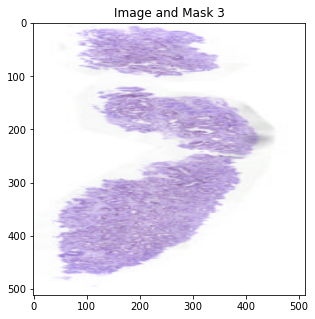

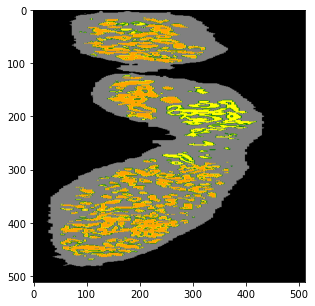

In [10]:
# Print out an example image,and mask 
test_id = 3
 
plt.figure(figsize = (5,5))
plt.title("Image and Mask {}".format(test_id))
plt.imshow(plt.imread(data_dir + '/'
                      + train_df.iloc[test_id]['image_id'] + '.png'))

plt.figure(figsize = (5,5))
plt.imshow(plt.imread(mask_dir + '/'
                      + train_df.iloc[test_id]['image_id'] + '_mask.png'))

In [11]:
# Separate images into training and validation set.
# The training ratio can be changed, typically set to 75-85%.
training_ratio = 0.85 
msk = np.random.rand(len(train_df)) < training_ratio

# Create the training data and the mask data.
train = train_df[msk]
valid = train_df[~msk]

In [12]:
# Either use the images or use the masks for training. Found that training using masks show better results.
data_dir = '/kaggle/input/panda-image-and-cmapped-mask-data/train_images/train_images/'
mask_dir = '/kaggle/input/panda-image-and-cmapped-mask-data/train_label_masks/train_label_masks/'

use_images = False

if use_images:
    train_paths = train["image_id"].apply(lambda x: GCS_DS_PATH + '/train_images/train_images/' + x + '.png').values
    valid_paths = valid["image_id"].apply(lambda x: GCS_DS_PATH + '/train_images/train_images/' + x + '.png').values
else:
    train_paths = train["image_id"].apply(lambda x: GCS_DS_PATH + '/train_label_masks/train_label_masks/' + x + '_mask.png').values
    valid_paths = valid["image_id"].apply(lambda x: GCS_DS_PATH + '/train_label_masks/train_label_masks/' + x + '_mask.png').values

In [13]:
# The isup_grade labels are read from the training and validation dataframe
train_labels = pd.get_dummies(train['isup_grade']).astype('int32').values
valid_labels = pd.get_dummies(valid['isup_grade']).astype('int32').values

print(train_labels.shape) 
print(valid_labels.shape)

(4264, 6)
(796, 6)


In [14]:
# Set up some training parameters
BATCH_SIZE= 8 * strategy.num_replicas_in_sync
img_size = 512
EPOCHS = 20
nb_classes = 6

Learning rate schedule: 1e-05 to 0.0008 to 0.000217


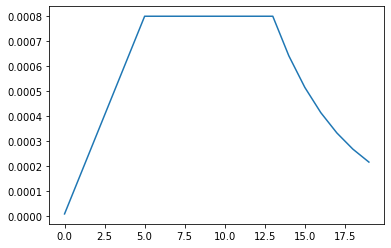

In [15]:
# Set the learning rate adaptively, this code recommendation is provided by Google.
# Also experimented with fixed learning rate, it was slightly worse, hence use Google recommendation.
# See reference: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

LR_START = 0.00001

LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 8
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [16]:
# This helper function takes filename as input and returns the image bytes as an array
def decode_image(filename, label=None, image_size=(img_size, img_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    if label is None:
        return image
    else:
        return image, label

In [17]:
# Set up the training dataset as per tensorflow documentation
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .repeat()
    .cache()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )

In [18]:
# Set up the Validation dataset as per tensorflow documentation
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [19]:
# Define the model based on efficientnet B7 version CNN, using imagenet pre-trained weights.
# In order to make it a classification model, introduce a softmax layer with n classes at the 
# output.
def get_model(input_shape=(None, None, 3)):
    base_model =  efn.EfficientNetB7(weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape)
    x = base_model.output
    
    # Predict isup score, use a dense layer with softmax activation.
    predictions = Dense(nb_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

In [20]:
with strategy.scope():
    model = get_model((img_size, img_size, 3))
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy', tf.keras.metrics.Recall()])

258441216/258434480 [==============================] - 3s 0us/step


In [22]:
%%time
history = model.fit(
            train_dataset, 
            validation_data = valid_dataset, 
            steps_per_epoch = train_labels.shape[0] // BATCH_SIZE,            
            validation_steps = valid_labels.shape[0] // BATCH_SIZE,            
            callbacks = [lr_callback],
            epochs = EPOCHS
)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
66/66 [==============================] - 313s 2s/step - loss: 1.7733 - accuracy: 0.2143 - recall: 0.0000e+00 - val_loss: 1.7730 - val_accuracy: 0.2227 - val_recall: 0.0000e+00
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000168.
66/66 [==============================] - 71s 1s/step - loss: 1.3847 - accuracy: 0.4733 - recall: 0.1685 - val_loss: 1.1998 - val_accuracy: 0.4974 - val_recall: 0.3372
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000326.
66/66 [==============================] - 76s 1s/step - loss: 0.9639 - accuracy: 0.6244 - recall: 0.4941 - val_loss: 1.0128 - val_accuracy: 0.6224 - val_recall: 0.5534
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000484.
66/66 [==============================] - 75s 1s/step - loss: 0.8566 - accuracy: 0.6705 - recall: 0.5881 - val_loss: 0.9790 - val_accuracy: 0.6484 - val_recall: 0

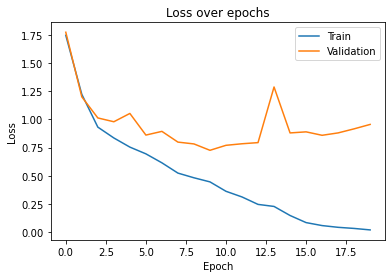

In [23]:
# Print some training statistics
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [28]:
# Save model
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model.save('./model', options=save_locally) # saving in Tensorflow's "saved model" format

In [ ]:
# If we need to load weights back from file, for prediction inference.
# The model weights are loaded into the model.
# model.load_weights('./model')

****Decision Support Pipeline****

In [29]:
# Functions for getting counts of each tissue type.

# First count the number of pixels in Various colors
# https://stackoverflow.com/questions/59669715/fastest-way-to-find-the-rgb-pixel-color-count-of-image
def pixel_count(pngfile):
    # Open file and make sure it is RGB - not palette
    im = Image.open(pngfile).convert('RGB')
    
    # Make into numpy array
    na = np.array(im)
    
    # Arrange all pixels into a tall column of 3 RGB values and find unique rows (colours)
    colors, counts = np.unique(na.reshape(-1,3), axis=0, return_counts=1)
    
    return(colors, counts)


# Get the tissue type from the RGB value
# Radboud images: Prostate glands are individually labelled, valid values are:
    # 0 : background (non-tissue or unknown)
    # 1 : stroma (connective tissues, non-epithelium tissue)
    # 2 : healthy (benign) epithelium
    # 3 : cancerous epithelium (Gleason 3)
    # 4 : cancerous epithelium (Gleason 4)
    # 5  :cancerous epithelium (Gleason 5)
    # Mapped to (for display) = ["black", "gray", "green", "yellow", "orange", "red"]
def get_tissue_type_from_color(rgb):
    tissue_color = [[0, 0, 0], [128, 128, 128], [0, 128, 0], [255, 255, 0], [255, 165, 0], [255, 0, 0]]
    tissue_type = ['background', 'stroma', 'healthy', 'gleason3', 'gleason4', 'gleason5']

    # Return the matching tissue type for the input color
    for index, tissue_rgb in enumerate(tissue_color):
        if list(rgb) == tissue_rgb:
            return tissue_type[index]
    
    return None

 
# Get the counts for each tissue type in a dictionary
def get_tissue_counts(pngfile):
    c, v = pixel_count(pngfile)
    tissue_count = dict()
    for index, value in enumerate(c):
        tissue_count[get_tissue_type_from_color(value)] = v[index]
    
    return tissue_count

Decision support function

In [26]:
# Print decision support, given the gleason score and tissue_counts for each type of pixel
def decision_support(gleason, count_pixeltype_array):
    result = dict()
    if gleason in ["3+4", "4+3"]:
        result['percent_involvement'] = (sum(count_pixeltype_array[3:5]) / sum(count_pixeltype_array[1:5])) * 100
        result['ratio_3_4'] = count_pixeltype_array[3]/count_pixeltype_array[4]
    elif gleason in ["4+5", "5+4"]:
        result['percent_involvement'] = (sum(count_pixeltype_array[4:5]) / sum(count_pixeltype_array[1:5])) * 100
    elif gleason in ["3+3"]:
        result['percent_involvement'] = (sum(count_pixeltype_array[3:5]) / sum(count_pixeltype_array[1:5])) * 100
        result['healthy_core_area'] = (count_pixeltype_array[2] / sum(count_pixeltype_array[2:5])) * 100
    else:
        result['percent_involvement'] = 0
        result['healthy_core_area'] = 100
    
    return result

In [30]:
# Example of Decision support
test_id = 3
test_file = mask_dir + '/' + train_df.iloc[test_id]['image_id'] + '_mask.png'

print ("---------------------------- Results ---------------------------------")
print("ISUP = {}".format(train_df.iloc[test_id]['isup_grade']))
print("Gleason Score = {}".format(train_df.iloc[test_id]['gleason_score']))

test_tissue_counts = get_tissue_counts(test_file)
test_tissue_values = [test_tissue_counts['background'],
             test_tissue_counts['healthy'],
             test_tissue_counts['stroma'],
             test_tissue_counts['gleason3'],
             test_tissue_counts['gleason4'],
             test_tissue_counts['gleason5']]
print("Tissue counts: {} ".format(test_tissue_counts))
print("Decision: {}".format(
      decision_support(train_df.iloc[test_id]['gleason_score'], test_tissue_values
     )))

---------------------------- Results ---------------------------------
ISUP = 3
Gleason Score = 4+3
Tissue counts: {'background': 149937, 'healthy': 8005, 'stroma': 73610, 'gleason4': 20286, 'gleason3': 10306} 
Decision: {'percent_involvement': 27.263896191859686, 'ratio_3_4': 1.9683679410052397}
